# Imports

In [21]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *
import data_func.read_data as read_data
from scipy import stats



# Load datasets

In [22]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [23]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]

## Cleaning X

Found a hole in the X data on location A

1|2
---|---
![1](./feature_cleaning/img/X_A_1.png) | ![2](./feature_cleaning/img/X_A_2.png)

This prevents our aggregation method to match the target data after these data points

Trying to remove this point and reindex to fix the issue. 

In [24]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))

A: 
 136245
Int64Index([118664], dtype='int64')
136244


Same problem for B-set at `2022-05-02 23:00:00` and C-set at `2022-04-25 21:00:00`

In [25]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))

B: 
 134505
Int64Index([116916], dtype='int64')
134504
C: 
 134401
Int64Index([116244], dtype='int64')


134400


## Cleaning Y-data

`B` targets and `C` targets have lots of static values that seems like invalid data. 

Removing them with function below

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<AxesSubplot:title={'center':'Target C Clean'}, xlabel='time'>

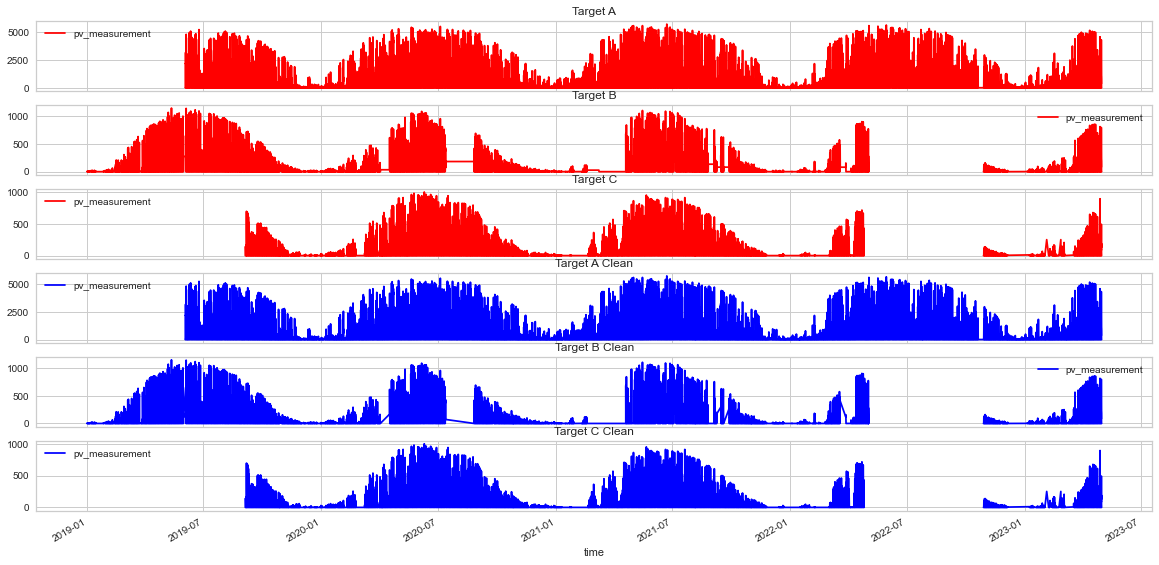

In [26]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [27]:
# Making sure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])

In [28]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))

x,y:  34060 34060
x,y:  29596 29596
x,y:  26028 26028


In [29]:
# Verifying that all train dataset still have their end data after aggregation in case of allignment issue
for x in X_train:
    print(x["date_forecast"].tail())

34055   2023-04-30 19:00:00
34056   2023-04-30 20:00:00
34057   2023-04-30 21:00:00
34058   2023-04-30 22:00:00
34059   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[ns]
29591   2023-04-30 19:00:00
29592   2023-04-30 20:00:00
29593   2023-04-30 21:00:00
29594   2023-04-30 22:00:00
29595   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[ns]
26023   2023-04-30 19:00:00
26024   2023-04-30 20:00:00
26025   2023-04-30 21:00:00
26026   2023-04-30 22:00:00
26027   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[ns]


# Feature engineering

In [30]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
import data_func.date_forecast as DTF

columns_to_drop = ['snow_density:kgm3', 'elevation:m', 'snow_drift:idx', 'date_forecast']

for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    X_train[i] = DTF.date_forecast_columns(X_train[i])

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DTF.date_forecast_columns(X_frames_test[i])

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
     temp = train.append(test, ignore_index = True)
     index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
     return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     #X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     #X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     #X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i].drop(columns=columns_to_drop, inplace=True)
     X_frames_test[i].drop(columns=columns_to_drop, inplace=True)

def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
        #df.drop(columns=features, inplace=True)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ["diffuse_rad_1h:J", "direct_rad_1h:J"],
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)


## Data Cleaning

In [31]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,6126,4588,5122
cloud_base_agl:m,2362,2025,2199


In [32]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88


In [33]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)

# Setting up the models

In [34]:
# Random Forest setup

def setup_experiment_rf(X_train, Y_train):

    X_train['target'] = Y_train

    exp_reg = setup(data = X_train, target = 'target', session_id = 123, 
                    categorical_features=['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx'], 
                    html=False, experiment_name='rf_experiment')
    
    random_forest = create_model('rf')
    # Tune model
    tuned_rf = tune_model(random_forest, optimize = 'MAE')

    # Create boosted model
    boosting_rf = ensemble_model(tuned_rf, method='Boosting')

    final_model = finalize_model(boosting_rf)

    return final_model

In [35]:
# LightGBM setup

def setup_experiment_lightgbm(X_train, Y_train):

    X_train['target'] = Y_train

    exp_reg = setup(data = X_train, target = 'target', session_id = 123, 
                    categorical_features=['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx'], 
                    html=False, experiment_name='lightgbm_experiment')
    
    lightgbm = create_model('lightgbm')
    # Tune model
    tuned_lightgbm = tune_model(lightgbm, optimize = 'MAE')

    # Create bagged model
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')

    final_model = finalize_model(bagged_lightgbm)

    return final_model

In [36]:
# Xgboost setup

def setup_experiment_xgboost(X_train, Y_train):

    X_train['target'] = Y_train

    exp_reg = setup(data = X_train, target = 'target', session_id = 123, 
                    categorical_features=['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx'], 
                    html=False, experiment_name='xgboost_experiment')
    
    xgboost = create_model('xgboost')
    
    # Tune model
    tuned_xgb = tune_model(xgboost, optimize = 'MAE')

    # Create bagged model
    bagged_xgb = ensemble_model(tuned_xgb, method='Bagging')

    final_model = finalize_model(bagged_xgb)

    return final_model

# Train and make predictions

In [37]:

from sklearn.linear_model import LinearRegression

all_preds_lgbm = []
all_preds_rf = []
all_preds_xgb = []

for i in range(len(X_train)):

  # Filter data for months March, April, May, June, July, August, September
  # X_train[i] = X_train[i][X_train[i]['date_forecast'].dt.month.isin([3,4,5,6,7,8,9])]
  # Setup models
  final_model_lgbm = setup_experiment_lightgbm(X_train[i], Y_train[i])
  final_model_rf = setup_experiment_rf(X_train[i], Y_train[i])
  final_model_xgb = setup_experiment_xgboost(X_train[i], Y_train[i])

  # Predictions
  preds_lgbm = predict_model(final_model_lgbm, data=X_frames_test[i])
  preds_rf = predict_model(final_model_rf, data=X_frames_test[i])
  preds_xgb = predict_model(final_model_xgb, data=X_frames_test[i])
  final_preds_lgbm = preds_lgbm['prediction_label']
  final_preds_rf = preds_rf['prediction_label']
  final_preds_xgb = preds_xgb['prediction_label']

  # Append predictions to list
  all_preds_lgbm.append(final_preds_lgbm)
  all_preds_rf.append(final_preds_rf)
  all_preds_xgb.append(final_preds_xgb)

                    Description                Value
0                    Session id                  123
1                        Target               target
2                   Target type           Regression
3           Original data shape          (34060, 57)
4        Transformed data shape          (34060, 63)
5   Transformed train set shape          (23842, 63)
6    Transformed test set shape          (10218, 63)
7              Ordinal features                    2
8              Numeric features                   52
9          Categorical features                    4
10                   Preprocess                 True
11              Imputation type               simple
12           Numeric imputation                 mean
13       Categorical imputation                 mode
14     Maximum one-hot encoding                   25
15              Encoding method                 None
16               Fold Generator                KFold
17                  Fold Number               

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     189.8695  162114.5257  402.6345  0.8819  1.2991  1.7109
1     183.8151  159210.8868  399.0124  0.8780  1.3086  1.4244
2     173.9275  139884.3268  374.0111  0.8945  1.2337  1.7492
3     171.8397  136333.1845  369.2332  0.9070  1.1968  1.5772
4     185.0043  162942.9183  403.6619  0.8802  1.2644  1.6625
5     181.3616  170647.2280  413.0947  0.8724  1.2735  1.6025
6     183.2707  176111.3092  419.6562  0.8721  1.2620  1.8214
7     183.9761  156604.7647  395.7332  0.8848  1.1996  1.4421
8     182.2010  150057.5231  387.3726  0.8931  1.2087  1.4088
9     187.6762  184337.4276  429.3453  0.8648  1.2782  1.3712
Mean  182.2942  159824.4095  399.3755  0.8829  1.2525  1.5770
Std     5.2912   14331.2017   17.9891  0.0119  0.0385  0.1508


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     185.8364  157705.2941  397.1213  0.8851  1.2103  1.4165
1     178.4339  155538.9263  394.3842  0.8808  1.2621  1.3864
2     179.5696  152009.5255  389.8840  0.8854  1.2131  1.5348
3     173.3078  140091.5488  374.2881  0.9044  1.2280  1.5619
4     182.1242  167163.1490  408.8559  0.8771  1.3743  1.6520
5     180.6966  164664.8813  405.7892  0.8769  1.3020  1.6314
6     176.0420  159139.4975  398.9229  0.8844  1.2946  1.8177
7     187.7258  161416.5537  401.7668  0.8812  1.2795  1.4344
8     184.7137  154215.9957  392.7034  0.8901  1.2315  1.3019
9     186.3985  182533.4546  427.2393  0.8661  1.2155  1.4202
Mean  181.4849  159447.8827  399.0955  0.8832  1.2611  1.5157
Std     4.5050   10484.9550   13.0634  0.0094  0.0499  0.1462


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     182.9540  157909.6179  397.3784  0.8850  1.0423  1.2896
1     177.2458  153672.2536  392.0105  0.8822  1.0542  1.1223
2     171.0700  142140.5918  377.0154  0.8928  1.0140  1.2517
3     167.2184  133222.1649  364.9961  0.9091  1.0187  1.4313
4     178.6048  162085.4390  402.5984  0.8808  1.0964  1.3104
5     177.5171  166236.6051  407.7212  0.8757  1.0757  1.6238
6     175.3771  164455.1183  405.5307  0.8806  1.0760  1.6070
7     181.2558  152788.1122  390.8812  0.8876  1.0605  1.2751
8     179.2937  148573.7840  385.4527  0.8941  1.0250  1.2077
9     182.6119  184034.0592  428.9919  0.8650  1.0740  1.2441
Mean  177.3149  156511.7746  395.2577  0.8853  1.0537  1.3363
Std     4.7509   13349.3144   16.8275  0.0112  0.0265  0.1580
                    Description          Value
0                    Session id            123
1                        Target       

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     189.7596  174142.4597  417.3038  0.8732  0.6350  1.3191
1     185.5616  167483.3242  409.2473  0.8716  0.5849  1.1477
2     181.6465  159114.7432  398.8919  0.8800  0.5752  1.1180
3     178.5772  149695.4554  386.9050  0.8978  0.5747  1.2747
4     187.3057  177102.3634  420.8353  0.8697  0.6214  1.3802
5     187.9729  190859.6751  436.8749  0.8573  0.5975  1.2827
6     187.8868  184481.3454  429.5129  0.8660  0.6171  1.6143
7     186.0205  162653.0269  403.3026  0.8803  0.5936  1.2347
8     187.6729  165739.2839  407.1109  0.8819  0.5881  1.1211
9     190.6899  201341.7746  448.7112  0.8524  0.6105  1.1472
Mean  186.3094  173261.3452  415.8696  0.8730  0.5998  1.2640
Std     3.4839   14824.3407   17.7154  0.0124  0.0194  0.1447


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     196.5972  181422.2866  425.9370  0.8679  0.6632  1.4347
1     189.1442  175483.6448  418.9077  0.8655  0.6177  1.2361
2     183.8971  161621.1118  402.0213  0.8781  0.6042  1.2411
3     180.0018  154591.8730  393.1817  0.8945  0.6069  1.3840
4     191.0715  183208.5233  428.0286  0.8653  0.6468  1.5088
5     192.8094  199247.8032  446.3718  0.8510  0.6374  1.3632
6     191.3862  196399.1840  443.1695  0.8573  0.6489  1.7395
7     190.8209  169070.1631  411.1814  0.8756  0.6317  1.3806
8     192.5528  170242.6249  412.6047  0.8787  0.6168  1.2291
9     193.9514  205910.6051  453.7737  0.8490  0.6265  1.2787
Mean  190.2233  179719.7820  423.5177  0.8683  0.6300  1.3796
Std     4.6339   15939.6504   18.7751  0.0132

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     189.8607  165753.8095  407.1287  0.8793  0.6472  1.4056
1     182.0327  157282.5779  396.5887  0.8795  0.5977  1.2268
2     177.7688  148087.8051  384.8218  0.8883  0.5884  1.2428
3     175.6218  141049.3288  375.5653  0.9037  0.5858  1.3557
4     184.3422  164165.1156  405.1729  0.8793  0.6254  1.4923
5     184.5553  176544.4119  420.1719  0.8680  0.6096  1.3636
6     182.6932  167981.0110  409.8549  0.8780  0.6237  1.6938
7     185.6321  157866.3833  397.3240  0.8838  0.6095  1.3327
8     187.1878  156769.6177  395.9414  0.8883  0.6005  1.2106
9     186.0734  182940.1610  427.7150  0.8659  0.6105  1.2158
Mean  183.5768  161844.0222  402.0285  0.8814  0.6098  1.3540
Std     4.0584   11847.0073   14.7353  0.0102  0.0176  0.1435
                    Description               Value
0                    Session id                 123
1                        Tar

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     192.5132  170147.0625  412.4889  0.8761  1.6095  1.9174
1     186.7997  163465.6562  404.3089  0.8747  1.6000  1.7801
2     184.7571  160281.6562  400.3519  0.8792  1.5653  1.6324
3     184.2409  153498.7344  391.7892  0.8952  1.5111  2.0554
4     188.2247  174689.3438  417.9586  0.8715  1.6208  2.1274
5     185.6221  175498.3906  418.9253  0.8688  1.6412  2.3701
6     188.7603  173787.6719  416.8785  0.8738  1.6706  2.5317
7     190.9067  164918.2812  406.1013  0.8787  1.6511  1.8663
8     186.3713  159718.0469  399.6474  0.8862  1.5383  1.6007
9     196.5922  194682.3594  441.2282  0.8572  1.6899  1.5568
Mean  188.4788  169068.7203  410.9678  0.8761  1.6098  1.9438
Std     3.6793   10991.4258   13.1978  0.0096  0.0547  0.3117


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     187.1848  164327.5781  405.3734  0.8803  1.2947  1.4180
1     176.4478  151266.7656  388.9303  0.8841  1.2352  1.4195
2     176.6386  147741.9531  384.3722  0.8886  1.3157  1.6889
3     168.7494  130517.9609  361.2727  0.9109  1.2952  1.9401
4     182.8154  160462.2812  400.5774  0.8820  1.3676  1.7936
5     176.7270  167071.8594  408.7442  0.8751  1.3005  1.4799
6     176.6947  152865.1875  390.9798  0.8890  1.2705  1.8268
7     182.7378  155866.4531  394.7993  0.8853  1.2992  1.5843
8     181.4480  147179.1094  383.6393  0.8951  1.2456  1.3708
9     185.4870  183620.8125  428.5100  0.8654  1.2726  1.4010
Mean  179.4931  156091.9961  394.7198  0.8856  1.2897  1.5923
Std     5.1847   13424.8180   16.9775  0.0115  0.0355  0.1960


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     180.7709  154123.5938  392.5858  0.8877  1.0503  1.3016
1     174.1221  146989.4531  383.3920  0.8873  1.0704  1.1547
2     169.4544  138664.4219  372.3767  0.8955  1.0294  1.2717
3     165.9960  130451.0469  361.1801  0.9110  1.0251  1.3600
4     175.4933  153221.3125  391.4349  0.8873  1.0959  1.3350
5     174.2255  162461.4219  403.0650  0.8785  1.0497  1.5816
6     173.0709  158808.9375  398.5084  0.8847  1.0869  1.7841
7     177.6946  149779.5938  387.0137  0.8898  1.0478  1.3432
8     179.7524  148761.8750  385.6966  0.8940  1.0189  1.2636
9     179.5098  177904.1406  421.7868  0.8695  1.1169  1.1192
Mean  175.0090  152116.5797  389.7040  0.8885  1.0591  1.3515
Std     4.4794   12310.1953   15.7278  0.0103  0.0309  0.1870
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] fea

          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     22.5218  2808.0493  52.9910  0.9295  0.8718  1.0268
1     25.2425  3920.4446  62.6135  0.9123  0.8082  1.1522
2     24.6847  3543.1631  59.5245  0.9166  0.8784  1.1359
3     24.2175  3777.5907  61.4621  0.9047  0.7883  0.7801
4     23.5045  3226.1933  56.7996  0.9189  0.8829  1.0097
5     23.5450  3434.5015  58.6046  0.9036  0.7827  1.1337
6     24.6008  3752.4802  61.2575  0.9101  0.8695  1.4048
7     25.3572  3857.7224  62.1106  0.9129  0.8948  1.0930
8     24.2865  3416.8788  58.4541  0.9210  0.8863  1.2183
9     23.6213  3207.6744  56.6363  0.9208  0.8591  1.2696
Mean  24.1582  3494.4698  59.0454  0.9150  0.8522  1.1224
Std    0.8292   331.2881   2.8484  0.0076  0.0402  0.1586


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     23.8086  3242.8196  56.9458  0.9186  0.9192  0.9021
1     25.2206  3915.8794  62.5770  0.9124  0.8322  1.2234
2     26.1609  4014.1426  63.3573  0.9055  0.9129  1.0645
3     25.2449  3855.7746  62.0949  0.9027  0.8596  0.7648
4     23.9029  3334.6274  57.7462  0.9162  0.9256  0.8535
5     23.7543  3553.6607  59.6126  0.9002  0.7971  1.1229
6     26.1070  4381.6959  66.1944  0.8951  0.8862  1.2486
7     25.7296  3981.5498  63.0995  0.9101  0.9102  1.0119
8     24.7279  3677.9462  60.6461  0.9150  0.8894  1.0762
9     24.8874  3630.9807  60.2576  0.9104  0.8987  1.0992
Mean  24.9544  3758.9077  61.2531  0.9086  0.8831  1.0367
Std    0.8634   323.7298   2.6385  0.0072  0.0395  0.1482


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     22.6741  2906.0474  53.9078  0.9270  0.8408  0.9773
1     25.3154  3953.7071  62.8785  0.9116  0.8024  1.2427
2     25.3953  3905.4721  62.4938  0.9080  0.8886  1.1776
3     23.9812  3586.4767  59.8872  0.9095  0.7635  0.7854
4     23.9317  3347.7951  57.8601  0.9158  0.8680  1.0048
5     23.3081  3409.1642  58.3880  0.9043  0.7842  1.1201
6     25.0180  3967.1312  62.9852  0.9050  0.8464  1.5565
7     25.5876  3967.7656  62.9902  0.9104  0.8894  1.0536
8     24.2228  3491.4011  59.0881  0.9193  0.8658  1.2306
9     23.6132  3231.5442  56.8467  0.9202  0.8640  1.2647
Mean  24.3048  3576.6505  59.7326  0.9131  0.8413  1.1413
Std    0.9352   348.1866   2.9449  0.0069  0.0415  0.1969
                    Description          Value
0                    Session id            123
1                        Target         target
2                   Target type     Regression


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     23.0090  3125.8010  55.9089  0.9215  0.7592  0.9838
1     26.2256  4388.0758  66.2426  0.9019  0.7766  1.2266
2     26.6637  4443.3947  66.6588  0.8954  0.8388  1.0485
3     25.1012  4068.6155  63.7857  0.8973  0.7114  0.7581
4     24.5606  3656.6277  60.4701  0.9081  0.8328  0.9905
5     24.1175  3731.4256  61.0854  0.8952  0.7415  1.3038
6     25.9827  4512.4892  67.1751  0.8919  0.8028  1.1770
7     26.8537  4701.6812  68.5688  0.8939  0.8531  1.0264
8     25.0885  3935.2208  62.7313  0.9090  0.8190  1.1021
9     24.5502  3758.2973  61.3050  0.9072  0.7974  1.0789
Mean  25.2153  4032.1629  63.3932  0.9021  0.7933  1.0696
Std    1.1561   459.7221   3.6703  0.0088  0.0434  0.1432


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     24.9240  3501.5221  59.1737  0.9121  0.8664  0.9919
1     27.0621  4396.3302  66.3048  0.9017  0.8185  1.2053
2     27.9112  4611.8781  67.9108  0.8914  0.9126  1.1914
3     26.1706  4275.3645  65.3863  0.8921  0.7702  0.7961
4     25.8677  3805.8040  61.6912  0.9043  0.9006  1.0342
5     24.8449  3947.3791  62.8282  0.8892  0.7810  1.3105
6     26.7403  4453.4688  66.7343  0.8934  0.8604  1.3365
7     28.0688  4790.9019  69.2163  0.8918  0.9222  1.1068
8     26.2805  4068.2838  63.7831  0.9059  0.9010  1.1738
9     25.3010  3812.1704  61.7428  0.9059  0.8677  1.1856
Mean  26.3171  4166.3103  64.4771  0.8988  0.8601  1.1332
Std    1.0821   386.1050   3.0013  0.0077  0.0511  0.1516


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     23.1660  3056.7765  55.2881  0.9233  0.8176  1.0111
1     25.2670  3841.3276  61.9784  0.9141  0.7926  1.3498
2     25.3082  3740.5100  61.1597  0.9119  0.8637  1.1482
3     24.3629  3669.2510  60.5743  0.9074  0.7389  0.7838
4     23.9990  3308.1711  57.5167  0.9168  0.8666  1.0657
5     23.4644  3503.6708  59.1918  0.9016  0.7605  1.2526
6     24.8052  3935.2873  62.7319  0.9058  0.8338  1.5019
7     25.2201  3870.4714  62.2131  0.9126  0.8630  1.1644
8     24.3053  3374.7153  58.0923  0.9220  0.8463  1.1602
9     23.1731  3126.5188  55.9153  0.9228  0.8299  1.2004
Mean  24.3071  3542.6700  59.4662  0.9138  0.8213  1.1638
Std    0.8001   299.9926   2.5386  0.0071  0.0422  0.1832
                    Description               Value
0                    Session id                 123
1                        Target              target
2                   Target type 

          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     23.8208  3336.1809  57.7597  0.9162  0.9690  0.8961
1     25.8243  3931.8755  62.7047  0.9121  0.9159  1.0211
2     24.9342  3749.1992  61.2307  0.9117  0.9690  1.1422
3     25.1390  3842.8020  61.9903  0.9030  0.9150  0.7718
4     23.4254  3192.3564  56.5009  0.9198  0.9922  0.9226
5     23.8985  3641.4146  60.3441  0.8978  0.8792  1.2499
6     25.6949  4149.5586  64.4171  0.9006  0.9615  1.0548
7     26.2326  4088.0425  63.9378  0.9077  1.0018  1.0542
8     25.1244  3766.1448  61.3689  0.9129  0.9935  1.1364
9     24.2514  3347.0405  57.8536  0.9174  0.9840  1.1417
Mean  24.8346  3704.4615  60.8108  0.9099  0.9581  1.0391
Std    0.8995   308.4662   2.5514  0.0070  0.0389  0.1347


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     23.2060  3206.8457  56.6290  0.9195  0.8550  0.8636
1     24.4574  3968.4121  62.9953  0.9112  0.8018  0.9918
2     24.6513  3751.8152  61.2521  0.9117  0.9007  1.0366
3     23.9001  3774.5312  61.4372  0.9047  0.8036  0.6931
4     22.1261  2929.9465  54.1290  0.9264  0.8530  0.8578
5     23.1467  3427.1626  58.5420  0.9038  0.8046  1.0129
6     23.6996  3806.9446  61.7004  0.9088  0.8338  1.1216
7     24.9407  3960.7910  62.9348  0.9106  0.9099  1.0199
8     23.2614  3315.6914  57.5820  0.9233  0.8783  1.2154
9     23.6362  3394.1965  58.2597  0.9162  0.8768  1.1021
Mean  23.7025  3553.6337  59.5462  0.9136  0.8517  0.9915
Std    0.7926   331.2606   2.8086  0.0072  0.0380  0.1435


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     22.1804  2924.9565  54.0829  0.9266  0.7813  0.8421
1     24.4302  3902.6746  62.4714  0.9127  0.7456  1.1086
2     24.5242  3810.5125  61.7293  0.9103  0.8555  1.0055
3     23.3976  3602.6555  60.0221  0.9091  0.7422  0.6796
4     22.4636  3043.9878  55.1723  0.9235  0.8288  0.8805
5     22.5405  3339.5564  57.7889  0.9062  0.7347  1.0506
6     24.7065  4053.7229  63.6689  0.9029  0.8052  1.2225
7     24.9918  3929.8528  62.6885  0.9113  0.8444  0.9736
8     23.6923  3503.7344  59.1924  0.9190  0.8272  1.0572
9     22.7072  3199.6475  56.5654  0.9210  0.8220  1.0400
Mean  23.5634  3531.1301  59.3382  0.9143  0.7987  0.9860
Std    0.9984   374.8846   3.1791  0.0074  0.0425  0.1447
                    Description                Value
0                    Session id                  123
1                        Target               target
2                   Target ty

          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     20.4242  2663.5343  51.6094  0.9006  0.8322  0.5335
1     19.4790  2198.0128  46.8830  0.9261  0.8149  0.5274
2     18.6091  1895.2656  43.5346  0.9305  0.8946  0.5592
3     19.7838  2377.5179  48.7598  0.9100  0.7635  0.5373
4     19.3623  2295.1021  47.9072  0.9075  0.8956  0.5688
5     19.9413  2226.9946  47.1910  0.9206  0.8762  0.5572
6     20.1277  2280.8003  47.7577  0.9121  0.8003  0.5398
7     20.9319  2635.6708  51.3388  0.9039  0.7842  0.5976
8     18.6811  2211.8976  47.0308  0.9234  0.8339  0.5497
9     19.7342  2457.1349  49.5695  0.9141  0.8028  0.6469
Mean  19.7075  2324.1931  48.1582  0.9149  0.8298  0.5617
Std    0.6843   213.8633   2.2319  0.0094  0.0436  0.0344


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     20.8277  2734.0365  52.2880  0.8980  0.8414  0.5910
1     19.8252  2355.7146  48.5357  0.9208  0.8029  0.5365
2     19.3539  2123.7774  46.0845  0.9221  0.8856  0.5687
3     20.2634  2545.5403  50.4533  0.9036  0.7487  0.5492
4     18.9963  2241.2455  47.3418  0.9097  0.8834  0.6193
5     20.5492  2462.2303  49.6209  0.9122  0.8429  0.5463
6     20.7871  2360.6169  48.5862  0.9090  0.8316  0.5415
7     21.5511  2770.7593  52.6380  0.8990  0.8396  0.6411
8     19.5134  2330.4412  48.2746  0.9193  0.8352  0.4905
9     20.6152  2658.6181  51.5618  0.9071  0.8461  0.6663
Mean  20.2283  2458.2980  49.5385  0.9101  0.8357  0.5750
Std    0.7504   204.1682   2.0584  0.0082  0.0369  0.0512


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     20.1900  2646.6431  51.4455  0.9012  0.8073  0.5222
1     19.2889  2187.8164  46.7741  0.9265  0.7814  0.5217
2     18.3759  1887.3674  43.4438  0.9308  0.8553  0.5673
3     20.0452  2425.6383  49.2508  0.9082  0.7450  0.5443
4     19.0255  2270.2662  47.6473  0.9085  0.8721  0.5894
5     19.8709  2245.8620  47.3905  0.9199  0.8534  0.5855
6     19.6669  2160.2273  46.4782  0.9167  0.7873  0.5278
7     21.0775  2590.5225  50.8972  0.9056  0.7952  0.6053
8     18.8363  2247.9830  47.4129  0.9222  0.8141  0.5566
9     19.9313  2476.0205  49.7596  0.9135  0.7977  0.6685
Mean  19.6308  2313.8347  48.0500  0.9153  0.8109  0.5689
Std    0.7359   214.0857   2.2432  0.0091  0.0371  0.0434
                    Description          Value
0                    Session id            123
1                        Target         target
2                   Target type     Regression


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     20.6376  2869.8012  53.5705  0.8929  0.7472  0.5779
1     19.7026  2445.6321  49.4533  0.9178  0.7122  0.5711
2     19.1791  2125.1161  46.0990  0.9220  0.7886  0.6100
3     19.8309  2507.1963  50.0719  0.9051  0.6580  0.5944
4     19.0256  2378.5269  48.7701  0.9042  0.7970  0.6216
5     20.3904  2578.3474  50.7774  0.9080  0.7784  0.5853
6     20.0408  2333.9308  48.3108  0.9100  0.7186  0.5372
7     21.7115  2854.3762  53.4264  0.8959  0.7357  0.6508
8     19.4200  2452.7490  49.5252  0.9151  0.7621  0.5725
9     20.3556  2686.4985  51.8314  0.9061  0.7448  0.7072
Mean  20.0294  2523.2175  50.1836  0.9077  0.7442  0.6028
Std    0.7539   220.4490   2.1960  0.0086  0.0393  0.0456


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     21.2750  2905.9767  53.9071  0.8916  0.8036  0.6083
1     20.0032  2455.7343  49.5554  0.9175  0.7619  0.5717
2     19.6601  2170.8478  46.5924  0.9204  0.8349  0.6159
3     20.1322  2535.1413  50.3502  0.9040  0.7030  0.6199
4     19.5656  2423.3282  49.2273  0.9024  0.8476  0.6541
5     21.0782  2638.0171  51.3616  0.9059  0.8305  0.6555
6     20.6107  2348.5796  48.4621  0.9095  0.7590  0.5562
7     21.9076  2787.8397  52.8000  0.8984  0.7724  0.6557
8     19.4603  2384.8001  48.8344  0.9174  0.7875  0.5706
9     20.8455  2728.3542  52.2337  0.9047  0.7840  0.6917
Mean  20.4538  2537.8619  50.3324  0.9072  0.7884  0.6200
Std    0.7790   214.0423   2.1236  0.0087  0.0410  0.0422


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     20.3345  2688.6152  51.8519  0.8997  0.7897  0.5984
1     19.2332  2264.9551  47.5915  0.9239  0.7443  0.5559
2     18.9307  2039.4050  45.1598  0.9252  0.8253  0.5982
3     19.6035  2340.9417  48.3833  0.9114  0.6905  0.6145
4     18.6919  2216.2581  47.0772  0.9107  0.8283  0.6134
5     19.9804  2435.0827  49.3466  0.9131  0.8151  0.5979
6     19.7483  2194.2521  46.8428  0.9154  0.7502  0.5199
7     21.5455  2745.6148  52.3986  0.8999  0.7669  0.6550
8     18.9846  2299.4137  47.9522  0.9204  0.7870  0.5676
9     20.4118  2647.6249  51.4551  0.9075  0.7760  0.6795
Mean  19.7464  2387.2163  48.8059  0.9127  0.7773  0.6000
Std    0.8199   223.9704   2.2807  0.0084  0.0401  0.0438
                    Description               Value
0                    Session id                 123
1                        Target              target
2                   Target type 

          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     20.6757  2707.5195  52.0338  0.8990  0.9342  0.5455
1     19.8233  2299.0493  47.9484  0.9227  0.9076  0.5282
2     19.7088  2080.3403  45.6107  0.9237  0.9713  0.6086
3     20.0955  2351.7239  48.4946  0.9110  0.8709  0.5322
4     19.2856  2249.5649  47.4296  0.9094  0.9923  0.6690
5     20.7066  2441.9526  49.4161  0.9129  0.9014  0.5560
6     19.8858  2199.2219  46.8959  0.9152  0.9038  0.4834
7     22.1040  2882.5422  53.6893  0.8949  0.9554  0.5730
8     19.4910  2309.8025  48.0604  0.9200  0.9118  0.5509
9     20.8596  2777.6243  52.7032  0.9029  0.9231  0.6169
Mean  20.2636  2429.9342  49.2282  0.9112  0.9272  0.5664
Std    0.7959   254.6757   2.5531  0.0093  0.0347  0.0502


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     20.3029  2628.6240  51.2701  0.9019  0.8155  0.5692
1     19.2203  2217.2939  47.0882  0.9255  0.7574  0.5073
2     17.8759  1883.6119  43.4006  0.9309  0.8609  0.5635
3     18.5351  2110.8757  45.9443  0.9201  0.7189  0.5077
4     18.3312  2123.2344  46.0786  0.9144  0.8717  0.5651
5     19.0840  2133.3765  46.1885  0.9239  0.8411  0.4843
6     19.2390  2118.9595  46.0322  0.9183  0.8043  0.4712
7     21.1695  2714.0703  52.0967  0.9011  0.8036  0.5792
8     18.7679  2314.7114  48.1114  0.9199  0.8218  0.5293
9     19.5086  2481.0544  49.8102  0.9133  0.8030  0.6252
Mean  19.2035  2272.5812  47.6021  0.9169  0.8098  0.5402
Std    0.9134   247.5277   2.5737  0.0091  0.0433  0.0457


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     19.3673  2502.9368  50.0294  0.9066  0.7685  0.5360
1     18.5461  2143.8103  46.3013  0.9279  0.7312  0.5117
2     17.7572  1827.3470  42.7475  0.9330  0.8113  0.5537
3     18.7237  2222.7844  47.1464  0.9159  0.6746  0.5333
4     18.0336  2097.6680  45.8003  0.9155  0.8198  0.5526
5     18.7958  2110.2517  45.9375  0.9247  0.7879  0.5265
6     19.1446  2168.6929  46.5692  0.9164  0.7402  0.5043
7     20.2285  2506.1807  50.0618  0.9086  0.7468  0.5846
8     18.2063  2167.8279  46.5599  0.9250  0.7747  0.5004
9     19.3489  2405.4907  49.0458  0.9159  0.7601  0.6390
Mean  18.8152  2215.2990  47.0199  0.9189  0.7615  0.5442
Std    0.6984   197.1019   2.1041  0.0080  0.0399  0.0398


# Evaluate prediction

In [40]:

all_preds_lgbm = np.array(all_preds_lgbm).flatten()
all_preds_rf = np.array(all_preds_rf).flatten()
all_preds_xgb = np.array(all_preds_xgb).flatten()

y_pred = all_preds_lgbm*0.6 + all_preds_rf*0.1 + all_preds_xgb*0.3

for i in range(len(y_pred)):
    if y_pred[i] < 0: 
        y_pred[i] = 0
print(len(y_pred))


2160


# Create submission

In [41]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_pyc_multiple.csv', index=False)